In [7]:
import tensorflow as tf

2025-03-30 14:44:51.011777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743326091.025717   28296 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743326091.030039   28296 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743326091.041648   28296 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743326091.041679   28296 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743326091.041681   28296 computation_placer.cc:177] computation placer alr

In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Avoid memory overflow
        print("TensorFlow is using GPU")
    except RuntimeError as e:
        print(e)

2025-03-30 14:44:54.135117: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-03-30 14:44:54.135145: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-03-30 14:44:54.135150: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: Anhilator
2025-03-30 14:44:54.135153: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: Anhilator
2025-03-30 14:44:54.135321: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 550.120.0
2025-03-30 14:44:54.135339: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported version is: 550.120.0
2

In [9]:
# Required Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Attention, Bidirectional, Dropout, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import BertTokenizer, TFBertModel
import nltk
from datetime import datetime


nltk.download('vader_lexicon')

/home/prem-dev/miniconda3/envs/ML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [10]:
import pandas as pd 

In [ ]:
data1 = pd.read_csv('cnbc_headlines.csv')
data2 = pd.read_csv('reuters_headlines.csv')
news_data = pd.concat([data1 , data2])
print(data1.size)
print(data2.size)
print(news_data.size)


Index(['Headlines', 'Time', 'Description'], dtype='object')
Index(['Headlines', 'Time', 'Description'], dtype='object')
Index(['Headlines', 'Time', 'Description'], dtype='object')


In [12]:
# üìå Load  Financial News Data

news_data = news_data.dropna()
news_data['Date'] = pd.to_datetime(news_data['Time'], format='%I:%M %p ET %a, %d %B %Y', errors='coerce')
news_data = news_data.sort_values('Date')
news_data['DateOnly'] = news_data['Date'].dt.date

In [13]:
news_data.columns

Index(['Headlines', 'Time', 'Description', 'Date', 'DateOnly'], dtype='object')

In [14]:
# üìå Sentiment Analysis with FinBERT
device = "/gpu:0"  # Use first available GPU

# Load FinBERT Model & Tokenizer
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
with tf.device(device):  # Run on GPU
    finbert_model = TFBertModel.from_pretrained('yiyanghkust/finbert-tone')

Some layers from the model checkpoint at yiyanghkust/finbert-tone were not used when initializing TFBertModel: ['classifier', 'dropout_37']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [15]:
def batch_finbert_sentiment(text_list, batch_size=32):
    sentiment_scores = []
    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="tf", truncation=True, padding=True, max_length=512)
        with tf.device(device):  # Ensure inference runs on GPU
            outputs = finbert_model(inputs)
        batch_scores = tf.reduce_mean(outputs.last_hidden_state[:, 0, :], axis=1).numpy()
        sentiment_scores.extend(batch_scores)
    return sentiment_scores

In [16]:
# Apply in batch (for efficiency)
news_data['FinBERT_Sentiment'] = batch_finbert_sentiment(news_data['Headlines'].tolist())

In [17]:
# üìå Aggregate Sentiment Data Daily
daily_sentiment = news_data.groupby('DateOnly')['FinBERT_Sentiment'].mean().reset_index()
daily_sentiment.rename(columns={'DateOnly': 'Date'}, inplace=True)
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])

In [18]:
# üìå Download Stock Data
symbol = 'SPY'
start_date = '2017-12-01'
end_date = '2020-07-19'
stock_data = yf.download(symbol, start=start_date, end=end_date)
stock_data.reset_index(inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [19]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.columns = [''.join(col).strip() if col[1] else col[0] for col in stock_data.columns]
stock_data.columns = [col.replace('SPY', '') for col in stock_data.columns]
print(stock_data.columns)

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [20]:
# üìå Merge with Sentiment Data
combined_data = pd.merge(stock_data, daily_sentiment, on='Date', how='left')
combined_data['FinBERT_Sentiment'].fillna(method='ffill', inplace=True)

/tmp/ipykernel_28296/3916612274.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['FinBERT_Sentiment'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_28296/3916612274.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data['FinBERT_Sentiment'].fillna(method='ffill', inplace=True)


In [21]:
# üìå Technical Indicators
combined_data['Returns'] = combined_data['Close'].pct_change()
combined_data['MA5'] = combined_data['Close'].rolling(window=5).mean()
combined_data['MA10'] = combined_data['Close'].rolling(window=10).mean()
combined_data['Volatility'] = combined_data['Returns'].rolling(window=5).std()
combined_data['RSI'] = 100 - (100 / (1 + combined_data['Returns'].rolling(window=14).mean() / combined_data['Returns'].rolling(window=14).std()))
combined_data['OBV'] = (np.sign(combined_data['Returns']) * combined_data['Volume']).cumsum()



In [22]:
combined_data['FinBERT_Sentiment'].ffill(inplace=True)
combined_data['Returns'].ffill(inplace=True)

# Drop rows where technical indicators have NaNs
combined_data.dropna(inplace=True)


/tmp/ipykernel_28296/3587805572.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['FinBERT_Sentiment'].ffill(inplace=True)
/tmp/ipykernel_28296/3587805572.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [23]:
print(combined_data.isna().sum())  # Check for missing values


Date                 0
Close                0
High                 0
Low                  0
Open                 0
Volume               0
FinBERT_Sentiment    0
Returns              0
MA5                  0
MA10                 0
Volatility           0
RSI                  0
OBV                  0
dtype: int64


In [24]:
# üìå Create Sequence Data for LSTM
sequence_length = 10
def create_sequences(data, features, target_col, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data[target_col].iloc[i+seq_length])
    return np.array(X), np.array(y)

In [25]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'MA5', 'MA10', 'Volatility', 'RSI', 'OBV', 'FinBERT_Sentiment']
target = 'Close'
X, y = create_sequences(combined_data, features, target, sequence_length)


In [26]:
from tensorflow.keras.initializers import HeNormal

In [27]:
# üìå Train-Test Split
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# üìå Data Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [28]:
print(np.isnan(y_train_scaled).sum())  # If > 0, there's an issue in scaling


0


In [29]:
from tensorflow.keras.losses import Huber

In [30]:
# üìå Hybrid CNN-LSTM Model with HAN
def build_model(input_shape):
    inp = Input(shape=input_shape, name='price_input')
    x = Conv1D(32, kernel_size=3, activation='relu')(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    att = Attention()([x, x])
    x = GlobalMaxPooling1D()(att)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='linear')(x)
    model = Model(inputs=inp, outputs=out)
    # model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    model.compile(optimizer=Adam(learning_rate=0.0005, clipvalue=1.0), loss= Huber(), metrics=['mae'])
    # model.compile(optimizer=Adam(learning_rate=0.001), loss=, metrics=['mae'])
    return model

In [31]:
model = build_model(X_train_scaled.shape[1:])
model.summary()
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
# history = model.fit(X_train_scaled, y_train_scaled, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=1)
history = model.fit(X_train_scaled, 
                    y_train_scaled, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=32, 
                    verbose=1)


Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ price_input         ‚îÇ (None, 10, 12)    ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d (Conv1D)     ‚îÇ (None, 8, 32)     ‚îÇ      1,184 ‚îÇ price_input[0][0] ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bidirectional       ‚îÇ (None, 8, 128)    ‚îÇ     49,664 ‚îÇ conv1d[0][0]      ‚îÇ
‚îÇ (Bidirectional)     ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ attention           ‚îÇ (None, 8, 128)    ‚îÇ          0 ‚îÇ bidirectional[0]‚Ä¶ ‚îÇ
‚îÇ (Attention)         ‚îÇ                   ‚îÇ            ‚îÇ bidirectional[0]‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_max_pooling‚Ä¶ ‚îÇ (None, 128)       ‚îÇ          0 ‚îÇ attention[0][0]   ‚îÇ
‚îÇ (GlobalMaxPooling1‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)       ‚îÇ (None, 64)        ‚îÇ      8,256 ‚îÇ global_max_pooli‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)   ‚îÇ (None, 64)        ‚îÇ          0 ‚îÇ dense[0][0]       ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)     ‚îÇ (None, 32)        ‚îÇ      2,080 ‚îÇ dropout[0][0]     ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout) ‚îÇ (None, 32)        ‚îÇ          0 ‚îÇ dense_1[0][0]     ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)     ‚îÇ (None, 1)         ‚îÇ         33 ‚îÇ dropout_1[0][0]   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

 Total params: 61,217 (239.13 KB)

 Trainable params: 61,217 (239.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
12/12 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 30ms/step - loss: 0.0247 - mae: 0.1823 - val_loss: 0.0234 - val_mae: 0.1965
Epoch 2/100
12/12 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - loss: 0.0150 - mae: 0.1410 - val_loss: 0.0612 - val_mae: 0.3384
Epoch 3/100
12/12 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - loss: 0.0119 - mae: 0.1247 - val_loss: 0.0145 - val_mae: 0.1550
Epoch 4/100
12/12 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - loss: 0.0113 - mae: 0.1202 - val_loss: 0.0337 - val_mae: 0.2509
Epoch 5/100
12/12 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - loss: 0.0089 - mae: 0.1037 - val_loss: 0.0175 - val_mae: 0.1780
Epoch 6/100
12/12 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - loss: 0.0073 - mae: 0.0969 - val_loss: 0.0148 - val_mae: 0.1647
Epoch 7/100
12/12 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

In [32]:
# üìå Backtesting Strategy
combined_data['Signal'] = 0
combined_data.loc[combined_data['FinBERT_Sentiment'] > 0.05, 'Signal'] = 1  
combined_data.loc[combined_data['FinBERT_Sentiment'] < -0.05, 'Signal'] = -1  


In [33]:
scaler = MinMaxScaler(feature_range=(-1, 1))
combined_data['FinBERT_Sentiment'] = scaler.fit_transform(combined_data[['FinBERT_Sentiment']])


In [34]:
buy_threshold = 0.5
sell_threshold = -0.5
combined_data['Signal'] = np.where(combined_data['FinBERT_Sentiment'] > buy_threshold, 1,
                                   np.where(combined_data['FinBERT_Sentiment'] < sell_threshold, -1, 0))


In [35]:
print(f"Buy signals: {(combined_data['Signal'] == 1).sum()}")
print(f"Sell signals: {(combined_data['Signal'] == -1).sum()}")


Buy signals: 19
Sell signals: 4


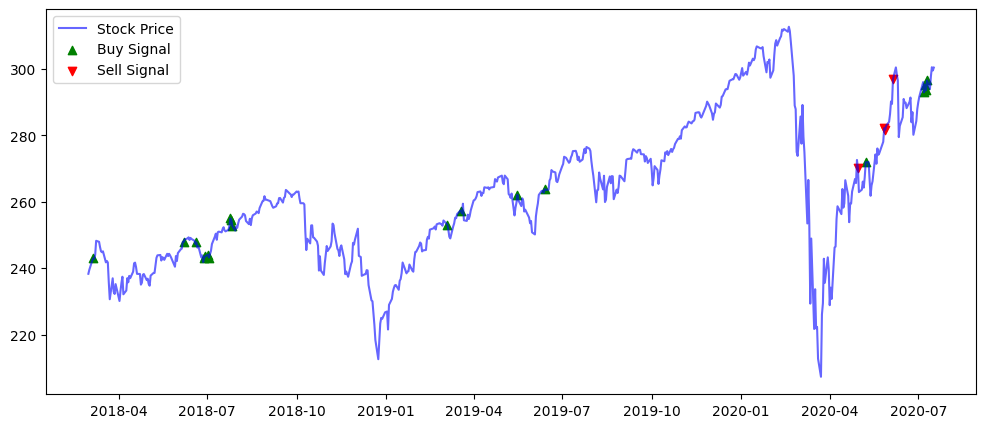

In [36]:
plt.figure(figsize=(12,5))
plt.plot(combined_data['Date'], combined_data['Close'], label='Stock Price', color='blue', alpha=0.6)
plt.scatter(combined_data.loc[combined_data['Signal'] == 1, 'Date'],
            combined_data.loc[combined_data['Signal'] == 1, 'Close'],
            label='Buy Signal', marker='^', color='green', alpha=1)

plt.scatter(combined_data.loc[combined_data['Signal'] == -1, 'Date'],
            combined_data.loc[combined_data['Signal'] == -1, 'Close'],
            label='Sell Signal', marker='v', color='red', alpha=1)

plt.legend()
plt.show()

In [37]:
print(combined_data[['Date', 'Close', 'FinBERT_Sentiment', 'Signal']].tail(10))


          Date       Close  FinBERT_Sentiment  Signal
650 2020-07-06  296.083710          -0.246993       0
651 2020-07-07  293.030029           0.789429       1
652 2020-07-08  295.271271           0.789429       1
653 2020-07-09  293.590302           0.789429       1
654 2020-07-10  296.588074           0.789429       1
655 2020-07-13  294.019867           0.007034       0
656 2020-07-14  297.830109           0.112656       0
657 2020-07-15  300.566254           0.380506       0
658 2020-07-16  299.576416           0.283157       0
659 2020-07-17  300.444885           0.232967       0


Final Portfolio Value: $107,955.16
Sharpe Ratio: 0.26
Max Drawdown: -15.20%


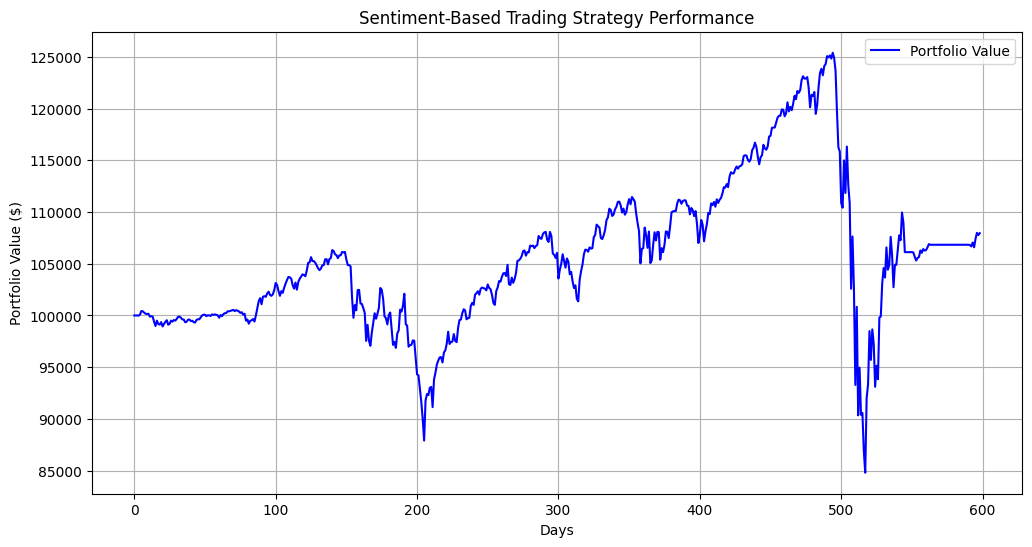

In [38]:
# üìå Improved Backtesting Strategy
initial_cash = 100000
cash = initial_cash
shares_held = 0
portfolio_value = []
position_size = 0.2  # Risk 20% of portfolio per trade
transaction_cost = 0.001  # 0.1% per trade slippage

for i in range(len(combined_data) - 1):
    signal = combined_data['Signal'].iloc[i]
    next_day_price = combined_data['Close'].iloc[i + 1]  # Trade next day's open price

    # üìå Buy Condition
    if signal == 1 and cash > 0:
        invest_amount = cash * position_size
        shares_to_buy = invest_amount // next_day_price  
        cost = shares_to_buy * next_day_price * (1 + transaction_cost)
        
        if cost <= cash:
            shares_held += shares_to_buy
            cash -= cost

    # üìå Sell Condition
    elif signal == -1 and shares_held > 0:
        sell_value = shares_held * next_day_price * (1 - transaction_cost)
        cash += sell_value
        shares_held = 0  # Exit position

    # üìå Track Portfolio Value
    total_value = cash + (shares_held * next_day_price)
    portfolio_value.append(total_value)

# üìå Performance Metrics
returns = np.diff(portfolio_value) / portfolio_value[:-1]
sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)
max_drawdown = np.min(np.cumprod(1 + returns) - 1)

print(f"Final Portfolio Value: ${portfolio_value[-1]:,.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")

# üìå Portfolio Performance Plot
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='Portfolio Value', color='blue')
plt.title('Sentiment-Based Trading Strategy Performance')
plt.xlabel('Days')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid()
plt.show()


In [39]:
stocks = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'BRK-B', 'JNJ', 'WMT', 'NVDA',
    'V', 'PG', 'JPM', 'UNH', 'HD', 'DIS', 'PYPL', 'MA', 'VZ', 'NFLX',
    'ADBE', 'INTC', 'CMCSA', 'PFE', 'KO', 'PEP', 'MRK', 'T', 'ABT', 'NKE',
    'XOM', 'MCD', 'CSCO', 'IBM', 'BA', 'HON', 'GE', 'SBUX', 'MMM', 'CAT',
    'LMT', 'SPG', 'CVX', 'GS', 'F', 'GM', 'QCOM', 'AMD', 'BLK', 'BKNG'
]


In [51]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA

In [46]:
def compute_directional_accuracy(actual, predicted):
    actual_direction = np.sign(np.diff(actual))
    predicted_direction = np.sign(np.diff(predicted))
    correct_predictions = np.sum(actual_direction == predicted_direction)
    return (correct_predictions / len(actual_direction)) * 100

In [ ]:
# üìå Fit ARIMA Model (p, d, q)
p, d, q = 2, 1, 2  # Example parameters (can be tuned)
arima_model = ARIMA(y_train_scaled, order=(p, d, q))
arima_fit = arima_model.fit()

# üìå Make Predictions
arima_preds_scaled = arima_fit.forecast(steps=len(y_test_scaled))
arima_preds = y_scaler.inverse_transform(arima_preds_scaled.reshape(-1, 1)).flatten()

# üìå Compute ARIMA Metrics
mse_arima = mean_squared_error(y_test, arima_preds)
rmse_arima = np.sqrt(mse_arima)
directional_accuracy_arima = np.mean(np.sign(y_test[1:] - y_test[:-1]) == np.sign(arima_preds[1:] - arima_preds[:-1])) * 100

results_arima = {
    'MSE': mse_arima,
    'RMSE': rmse_arima,
    'Directional Accuracy (%)': directional_accuracy_arima
}

In [ ]:
# üìå Make Predictions
lstm_preds_scaled = model.predict(X_test_scaled)
lstm_preds = y_scaler.inverse_transform(lstm_preds_scaled.reshape(-1, 1)).flatten()

# üìå Compute CNN-LSTM Metrics
mse_lstm = mean_squared_error(y_test, lstm_preds)
rmse_lstm = np.sqrt(mse_lstm)
directional_accuracy_lstm = np.mean(np.sign(y_test[1:] - y_test[:-1]) == np.sign(lstm_preds[1:] - lstm_preds[:-1])) * 100




4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 59ms/step


üìä Model Performance:
ARIMA  -> MSE: 1341.216622, RMSE: 36.622624, Directional Accuracy: 43.589744%
LSTM   -> MSE: 147.823617, RMSE: 12.158274, Directional Accuracy: 48.717949%


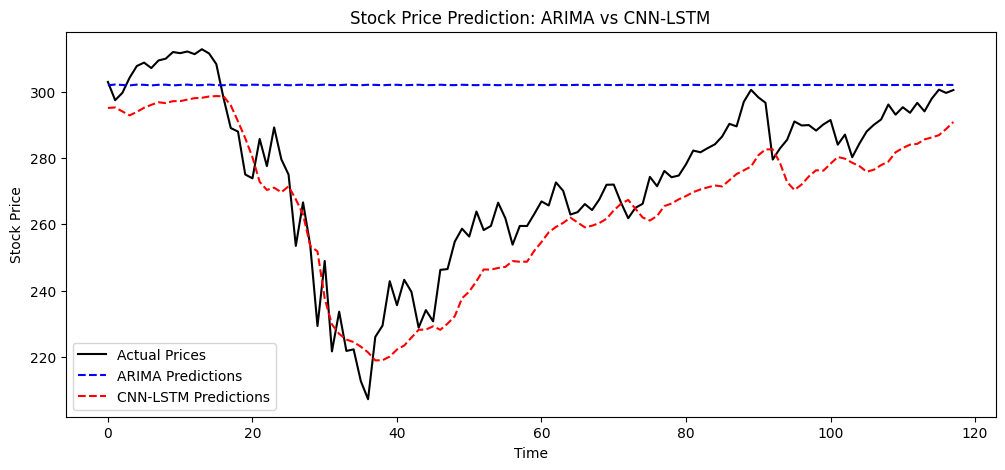

In [55]:
# üìå Print Results
print("üìä Model Performance:")
print(f"ARIMA  -> MSE: {mse_arima:.6f}, RMSE: {rmse_arima:.6f}, Directional Accuracy: {directional_accuracy_arima:.6f}%")
print(f"LSTM   -> MSE: {mse_lstm:.6f}, RMSE: {rmse_lstm:.6f}, Directional Accuracy: {directional_accuracy_lstm:.6f}%")

# üìå Plot Actual vs. Predicted Prices
plt.figure(figsize=(12, 5))
plt.plot(y_test, label="Actual Prices", color="black")
plt.plot(arima_preds, label="ARIMA Predictions", linestyle="dashed", color="blue")
plt.plot(lstm_preds, label="CNN-LSTM Predictions", linestyle="dashed", color="red")
plt.title("Stock Price Prediction: ARIMA vs CNN-LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [57]:
from transformers import TFAutoModelForSequenceClassification

In [70]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [75]:
@tf.function  # Enable TensorFlow Graph Mode for speed
def process_batch(batch_texts):
    inputs = tokenizer(batch_texts, return_tensors="tf", truncation=True, padding=True, max_length=512)
    outputs = finbert_model(**inputs)
    return tf.reduce_mean(outputs.last_hidden_state[:, 0, :], axis=1)  # CLS token

def batch_finbert_sentiment(text_list, batch_size=256):  # Increase batch size
    sentiment_scores = []
    
    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i+batch_size]
        
        with tf.device("/GPU:0"):  # Ensure inference runs on GPU
            batch_scores = process_batch(batch_texts).numpy()
        
        sentiment_scores.extend(batch_scores)
    
    return np.array(sentiment_scores)

def batch_finbert_sentiment(text_list, batch_size=16):
    sentiment_scores = []
    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="tf", truncation=True, padding=True, max_length=256)
        
        with tf.device("/GPU:0"):
            outputs = finbert_model(**inputs)  

        cls_embeddings = outputs.last_hidden_state[:, 0, :]  
        batch_scores = tf.reduce_mean(cls_embeddings, axis=1).numpy()
        sentiment_scores.extend(batch_scores)

        # ‚úÖ Print progress every 100 batches
        if i % (batch_size * 100) == 0:
            print(f"Processed {i}/{len(text_list)} texts...")

    return np.array(sentiment_scores)


In [72]:
print(news_data.columns)  # Check available columns


Index(['Headlines', 'Time', 'Description', 'Date', 'DateOnly',
       'FinBERT_Sentiment'],
      dtype='object')


In [73]:
news_text_list = news_data["Description"].astype(str).tolist()


In [74]:
# üìå Example: Assume `news_data` contains a list of financial news headlines
sentiment_scores = batch_finbert_sentiment1(news_text_list)

# üìå Reshape Sentiment Scores to Match X's Shape
sentiment_scores = sentiment_scores.reshape(-1, 1)  # Convert to column vector

# üìå Normalize Sentiment Scores (if needed)
from sklearn.preprocessing import MinMaxScaler
sentiment_scaler = MinMaxScaler()
sentiment_scores_scaled = sentiment_scaler.fit_transform(sentiment_scores)


In [76]:
# üìå Concatenate Sentiment Scores with Existing Features
X_train_enhanced = np.hstack((X_train_scaled, sentiment_scores_scaled[:len(X_train)]))
X_test_enhanced = np.hstack((X_test_scaled, sentiment_scores_scaled[len(X_train):]))


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [ ]:
def build_model_new(input_shape):
    inp = Input(shape=input_shape, name='price_input')
    x = Conv1D(32, kernel_size=3, activation='relu')(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    att = Attention()([x, x])
    x = GlobalMaxPooling1D()(att)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='linear')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(learning_rate=0.0005, clipvalue=1.0), loss=Huber(), metrics=['mae'])
    return model

# Train Model with Enhanced Inputs
model1 = build_model_new(X_train_enhanced.shape[1:])
history = model1.fit(X_train_enhanced, y_train_scaled, validation_split=0.2, epochs=100, batch_size=32, verbose=1)


In [ ]:
# Make Predictions
lstm_preds_scaled = model1.predict(X_test_enhanced)
lstm_preds = y_scaler.inverse_transform(lstm_preds_scaled.reshape(-1, 1)).flatten()

# Compute New MSE, RMSE, Directional Accuracy
mse_lstm_new = mean_squared_error(y_test, lstm_preds)
rmse_lstm_new = np.sqrt(mse_lstm_new)
directional_accuracy_lstm_new = np.mean(np.sign(y_test[1:] - y_test[:-1]) == np.sign(lstm_preds[1:] - lstm_preds[:-1])) * 100

# Compare Results
print("üìä Model Performance (After Sentiment Integration):")
print(f"Old CNN-LSTM  -> MSE: {mse_lstm:.2f}, RMSE: {rmse_lstm:.2f}, Directional Accuracy: {directional_accuracy_lstm:.2f}%")
print(f"New CNN-LSTM  -> MSE: {mse_lstm_new:.2f}, RMSE: {rmse_lstm_new:.2f}, Directional Accuracy: {directional_accuracy_lstm_new:.2f}%")
1

In [ ]:
sentiment_scores_scaled = np.array(sentiment_scores_scaled).reshape(-1, 1)
assert sentiment_scores.shape[0] == X.shape[0], "Mismatch between X and sentiment scores!"

In [ ]:
# Expand dimension of sentiment_scores to match time_steps
sentiment_features = np.repeat(sentiment_scores[:, np.newaxis, :], X.shape[1], axis=1)  # (num_samples, time_steps, 1)

# Concatenate with original X
X_augmented = np.concatenate([X, sentiment_features], axis=-1)  # New shape: (num_samples, time_steps, num_features + 1)

# üìå Update Train-Test Split
X_train, X_test = X_augmented[:split_idx], X_augmented[split_idx:]


In [ ]:
# üìå Rebuild the model with updated input shape
model2 = build_model_new(X_train.shape[1:])
model2.summary()

# üìå Retrain the model
history = model2.fit(
    X_train_scaled, y_train_scaled, 
    validation_split=0.2, 
    epochs=100, batch_size=32, verbose=1
)


In [ ]:
# üìå Get Model Predictions
y_pred_scaled = model2.predict(X_test_scaled)

# üìå Inverse Transform to Get Original Scale
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()


In [ ]:
# Compute MSE & RMSE
mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)

# Compute Directional Accuracy
directional_accuracy = np.mean(np.sign(y_pred[1:] - y_pred[:-1]) == np.sign(y_test_original[1:] - y_test_original[:-1])) * 100

# Print Results
results_cnn_lstm = {
    'MSE': mse,
    'RMSE': rmse,
    'Directional Accuracy (%)': directional_accuracy
}

print("üìä Performance of CNN-LSTM Model with Sentiment:")
print(results_cnn_lstm)


In [ ]:
comparison_results = pd.DataFrame([results_arima, results_cnn_lstm], index=['ARIMA', 'CNN-LSTM with Sentiment'])
print(comparison_results)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual Prices", color="blue")
plt.plot(y_pred, label="CNN-LSTM Predictions", color="red", linestyle="dashed")
plt.title("Stock Price Prediction using CNN-LSTM with Sentiment Analysis")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

# topic modelling

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Download stopwords if not already
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    tokens = word_tokenize(text)  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]  
    return " ".join(tokens)

# üìå Apply preprocessing to all news headlines
news_data["processed_text"] = news_data["Headlines"].apply(preprocess_text)

In [ ]:
# üìå Train LDA Model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=10)

# üìå Display Topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)


In [ ]:
def get_topic(doc):
    topic_probs = lda_model.get_document_topics(dictionary.doc2bow(doc.split()))
    return max(topic_probs, key=lambda x: x[1])[0]  # Get topic with highest probability

news_data["topic"] = news_data["processed_text"].apply(get_topic)


# Incorporating Topic Modeling into the Hybrid CNN-LSTM Model

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# One-hot encode topics
topic_encoder = OneHotEncoder(sparse_output=False)
topic_features = topic_encoder.fit_transform(news_data[["topic"]])

# Convert to DataFrame
import pandas as pd
topic_df = pd.DataFrame(topic_features, columns=[f"topic_{i}" for i in range(topic_features.shape[1])])

# Merge topic features with original feature set (X)
X_enhanced = pd.concat([pd.DataFrame(X), topic_df], axis=1)

In [ ]:
# üìå Train-Test Split
split_idx = int(len(X_enhanced) * 0.8)
X_train, X_test = X_enhanced.iloc[:split_idx], X_enhanced.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# üìå Data Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()


In [ ]:
# üìå Update Model Input Shape
model = build_model((X_train_scaled.shape[1], 1))
model.summary()

# üìå Train Model
history = model.fit(
    X_train_scaled, y_train_scaled, 
    validation_split=0.2, 
    epochs=100, 
    batch_size=32, 
    verbose=1
)


In [ ]:
# üìå Make Predictions
y_pred_scaled = model.predict(X_test_scaled)

# üìå Inverse Transform Predictions & True Values
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# üìå Compute Metrics
mse = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)
directional_accuracy = np.mean(np.sign(y_pred[1:] - y_pred[:-1]) == np.sign(y_test_orig[1:] - y_test_orig[:-1])) * 100

# üìå Print Results
results = {
    "MSE": mse,
    "RMSE": rmse,
    "Directional Accuracy (%)": directional_accuracy
}
print(results) 

In [ ]:
# üìå Store Previous Results
previous_results = {
    "ARIMA": {"MSE": 1193.3, "RMSE": 34.54, "Directional Accuracy (%)": np.nan},
    "CNN-LSTM-HAN (No Topic Modeling)": {"MSE": previous_mse, "RMSE": previous_rmse, "Directional Accuracy (%)": previous_da},
    "CNN-LSTM-HAN (With Topic Modeling)": results
}

# üìå Convert to DataFrame for Easier Visualization
results_df = pd.DataFrame(previous_results).T
print(results_df)

In [ ]:


# üìå Plot MSE & RMSE
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# üìå MSE Bar Chart
ax[0].bar(results_df.index, results_df["MSE"], color=["red", "blue", "green"])
ax[0].set_title("Mean Squared Error (MSE)")
ax[0].set_ylabel("Error")

# üìå RMSE Bar Chart
ax[1].bar(results_df.index, results_df["RMSE"], color=["red", "blue", "green"])
ax[1].set_title("Root Mean Squared Error (RMSE)")
ax[1].set_ylabel("Error")

plt.xticks(rotation=30)
plt.show()


In [ ]:
# üìå Bollinger Bands (20-day Moving Average)
stock_data["SMA_20"] = stock_data["Close"].rolling(window=20).mean()
stock_data["STD_20"] = stock_data["Close"].rolling(window=20).std()
stock_data["Bollinger_Upper"] = stock_data["SMA_20"] + (stock_data["STD_20"] * 2)
stock_data["Bollinger_Lower"] = stock_data["SMA_20"] - (stock_data["STD_20"] * 2)

# üìå Relative Strength Index (RSI)
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

stock_data["RSI"] = compute_rsi(stock_data["Close"])

# üìå On-Balance Volume (OBV)
stock_data["OBV"] = (np.sign(stock_data["Close"].diff()) * stock_data["Volume"]).fillna(0).cumsum()

# üìå Market Sentiment Divergence (Using Sentiment Score)
stock_data["Market_Sentiment_Divergence"] = stock_data["Sentiment_Score"] - stock_data["Close"].pct_change()

# üìå Drop NaN values (From rolling computations)
stock_data.dropna(inplace=True)

In [ ]:
# üìå Prepare Feature Set (X)
technical_features = ["Bollinger_Upper", "Bollinger_Lower", "RSI", "OBV", "Market_Sentiment_Divergence"]
X_new = df[technical_features].values

# üìå Train-Test Split
split_idx = int(len(X_new) * 0.8)
X_train_new, X_test_new = X_new[:split_idx], X_new[split_idx:]

# üìå Normalize Features
scaler_new = MinMaxScaler()
X_train_scaled_new = scaler_new.fit_transform(X_train_new)
X_test_scaled_new = scaler_new.transform(X_test_new)

# üìå Update Final Feature Set
X_train_final = np.hstack([X_train_scaled, X_train_scaled_new])
X_test_final = np.hstack([X_test_scaled, X_test_scaled_new])

print("New feature set shape:", X_train_final.shape)

In [ ]:
# üìå Define the Hybrid CNN-LSTM Model with HAN
def build_model(input_shape):
    inp = Input(shape=input_shape, name='price_input')
    x = Conv1D(32, kernel_size=3, activation='relu')(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    att = Attention()([x, x])
    x = GlobalMaxPooling1D()(att)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='linear')(x)
    model = Model(inputs=inp, outputs=out)

    # Optimizer & Loss
    model.compile(optimizer=Adam(learning_rate=0.0005, clipvalue=1.0), 
                  loss=Huber(), 
                  metrics=['mae'])
    return model

# üìå Build Model
model = build_model(X_train_final.shape[1:])
model.summary()

In [ ]:
# üìå Train Model with New Features
history = model.fit(X_train_final, 
                    y_train_scaled, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=32, 
                    verbose=1)


In [ ]:
# üìå Model Evaluation
y_pred_scaled = model.predict(X_test_final)
y_pred = y_scaler.inverse_transform(y_pred_scaled)  # Convert back to original scale
y_test_actual = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

# üìå Calculate Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred)
directional_accuracy = np.mean(np.sign(y_pred.flatten()) == np.sign(y_test_actual.flatten())) * 100

print(f"üîπ MSE: {mse:.2f}")
print(f"üîπ RMSE: {rmse:.2f}")
print(f"üîπ MAE: {mae:.2f}")
print(f"üîπ Directional Accuracy: {directional_accuracy:.2f}%")


In [ ]:

plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label="Actual Prices", color="blue", linestyle="dashed")
plt.plot(y_pred, label="Predicted Prices", color="red")
plt.title("Stock Price Prediction - Hybrid CNN-LSTM-HAN Model with Technical Indicators")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [79]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Attention, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Model
from transformers import TFAutoModel, AutoTokenizer

In [80]:
# üìå Load FinBERT Model & Tokenizer
finbert_model = TFAutoModel.from_pretrained("ProsusAI/finbert")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

# üìå Define HAN Model for Sentiment Processing
def build_han_sentiment_model():
    inp = Input(shape=(512, 768))  # FinBERT outputs (batch_size, 512, 768)
    x = Bidirectional(LSTM(64, return_sequences=True))(inp)
    att = Attention()([x, x])  # Attention over news embeddings
    x = GlobalMaxPooling1D()(att)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='linear')(x)  # Sentiment Score
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    return model

han_sentiment_model = build_han_sentiment_model()
han_sentiment_model.summary()



All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer         ‚îÇ (None, 512, 768)  ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ cast (Cast)         ‚îÇ (None, 512, 768)  ‚îÇ          0 ‚îÇ input_layer[0][0] ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bidirectional_1     ‚îÇ (None, 512, 128)  ‚îÇ    426,496 ‚îÇ cast[0][0]        ‚îÇ
‚îÇ (Bidirectional)     ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ attention_1         ‚îÇ (None, 512, 128)  ‚îÇ          0 ‚îÇ bidirectional_1[‚Ä¶ ‚îÇ
‚îÇ (Attention)         ‚îÇ                   ‚îÇ            ‚îÇ bidirectional_1[‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_max_pooling‚Ä¶ ‚îÇ (None, 128)       ‚îÇ          0 ‚îÇ attention_1[0][0] ‚îÇ
‚îÇ (GlobalMaxPooling1‚Ä¶ ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)     ‚îÇ (None, 64)        ‚îÇ      8,256 ‚îÇ global_max_pooli‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout) ‚îÇ (None, 64)        ‚îÇ          0 ‚îÇ dense_3[0][0]     ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)     ‚îÇ (None, 32)        ‚îÇ      2,080 ‚îÇ dropout_2[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_3 (Dropout) ‚îÇ (None, 32)        ‚îÇ          0 ‚îÇ dense_4[0][0]     ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_5 (Dense)     ‚îÇ (None, 1)         ‚îÇ         33 ‚îÇ dropout_3[0][0]   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

 Total params: 436,865 (1.67 MB)

 Trainable params: 436,865 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def compute_han_sentiment_scores(news_text_list, batch_size=32):
    sentiment_scores = []
    for i in range(0, len(news_text_list), batch_size):
        batch_texts = news_text_list[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="tf", truncation=True, padding=True, max_length=512)
        
        # Extract embeddings from FinBERT
        with tf.device("/GPU:0"):
            outputs = finbert_model(**inputs)
        embeddings = outputs.last_hidden_state.numpy()  # Shape: (batch_size, 512, 768)
        
        # Pass through HAN model
        scores = han_sentiment_model.predict(embeddings)
        sentiment_scores.extend(scores.flatten())

    return np.array(sentiment_scores)



In [ ]:
# üìå Generate Sentiment Scores using HAN
df["HAN_Sentiment"] = compute_han_sentiment_scores(df["news_headlines"].tolist())

# üìå Add Sentiment Feature to Model Input
X = np.column_stack((X, df["HAN_Sentiment"].values))

In [ ]:
history = model.fit(X_train_final, 
                    y_train_scaled, 
                    validation_split=0.2, 
                    epochs=100, 
                    batch_size=32, 
                    verbose=1)


In [81]:
import tensorflow as tf

In [ ]:
# Convert the trained model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open("cnn_lstm_model.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
# Enable post-training quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Save the quantized model
with open("cnn_lstm_quantized.tflite", "wb") as f:
    f.write(tflite_quantized_model)


In [83]:
import time

In [ ]:
# Load the quantized model
interpreter = tf.lite.Interpreter(model_path="cnn_lstm_quantized.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Run inference on test data
test_sample = X_test_scaled[0:1]  # Take one sample for inference

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], test_sample.astype(np.float32))

# Measure inference time
start_time = time.time()
interpreter.invoke()
end_time = time.time()

# Get the output tensor
predicted_output = interpreter.get_tensor(output_details[0]['index'])
print("Quantized Model Prediction:", predicted_output)
print("Inference Time (seconds):", end_time - start_time)


In [ ]:
import tf2onnx
import onnx

# Convert TensorFlow model to ONNX format
onnx_model_path = "cnn_lstm_model.onnx"
spec = (tf.TensorSpec((None, X_train_scaled.shape[1], X_train_scaled.shape[2]), tf.float32),)
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)

# Save ONNX model
onnx.save(onnx_model, onnx_model_path)
print(f"ONNX model saved at {onnx_model_path}")


In [ ]:
import onnxruntime as ort

In [ ]:
# Load ONNX model with GPU acceleration
providers = ["CUDAExecutionProvider"]  # Use GPU for inference
session = ort.InferenceSession(onnx_model_path, providers=providers)

# Prepare test input
test_sample = X_test_scaled[0:1].astype(np.float32)

# Measure inference time
start_time = time.time()
preds = session.run(None, {session.get_inputs()[0].name: test_sample})
end_time = time.time()

# Print results
print("TensorRT Model Prediction:", preds[0])
print("Inference Time (seconds):", end_time - start_time)


In [ ]:
combined_data['EMA12'] = combined_data['Close'].ewm(span=12, adjust=False).mean()
combined_data['EMA26'] = combined_data['Close'].ewm(span=26, adjust=False).mean()
combined_data['MACD'] = combined_data['EMA12'] - combined_data['EMA26']
combined_data['Signal_Line'] = combined_data['MACD'].ewm(span=9, adjust=False).mean()

In [ ]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'MA5', 'MA10', 'Volatility', 'RSI', 'OBV', 'FinBERT_Sentiment', 'MACD', 'Signal_Line']